<a href="https://colab.research.google.com/github/Ssp24-1/CFD-Solvers/blob/main/VLM_CFD_Code_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0.005 0.025 0.045 0.065 0.085 0.105 0.125 0.145 0.165 0.185 0.205]
Shape of vr_points: (11, 6, 3)


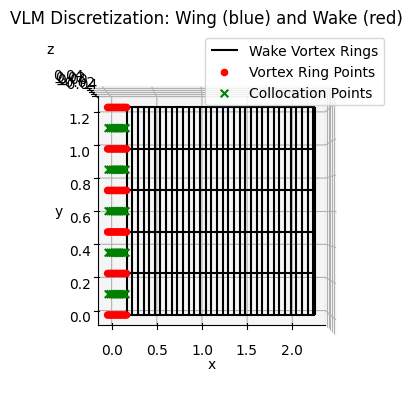

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def discretize(M, N, M_w, chord, span):
    """
    Discretizes wing geometry with bound vortex panels of MxN
    Discretization also includes the wake of the wing.

        Parameters:
        M : Chordwise Discretization Panels (int)
        N : Spanwise Discretization Panels (int)
        M_w : Chordwise Wake Panels (int)

        For this example, the chordwise spacing is constant and spanwise spacing is constant.

        Returns:
        Array with coordinates of all the panels (wing + wake), split into 2 arrays
    """
    x_vk = []
    y_vk = []
    z_vk = []

    x_wk = []
    y_wk = []
    z_wk = []

    #Chordwise Spacing (Constant Spacing) (Bound Vortex Rings)
    x_vk = np.linspace((chord/M)/4, chord + (chord/M)/4, M+1)

    #Spanwise Spacing (Constant Spacing) (Bound Vortex Rings)
    y_vk = np.linspace(0, span, N+1)

    z_vk = np.zeros_like(x_vk)


    #Spanwise Spacing (Cosine Spacing) (Bound Vortex Rings)
    # y_vk = np.array([(0.5 * (1 - np.cos(np.pi * j / N)) * span) for j in range(0, N+1)])

    # Chordwise Spacing (Wake Vortex Rings)
    x_wk = np.linspace(chord + (chord/M)/4, (chord + (chord/M)/4 + M*chord), M_w+1)

    #Spanwise Spacing (Bound Vortex Rings)
    y_wk = y_vk

    z_wk = np.zeros_like(x_wk)


    return x_vk, y_vk, z_vk, x_wk, y_wk, z_wk


def discretize_geo(M, N, chord, span):
    """
    Discretizes wing geometry into geometric panels
    On these panels, the bound vortex ring is attached at c/4 of each panel.

        Parameters:
        M : Chordwise Discretization Panels (int)
        N : Spanwise Discretization Panels (int)
        M_w : Chordwise Wake Panels (int)

        For this example, the chordwise spacing is constant and spanwise spacing is constant.

        Returns:
        Array with coordinates of all the panels
    """
    x_geo = []
    y_geo = []
    z_geo = []

    x_col = []
    y_col = []
    z_col = []

    #Chordwise Spacing (Constant Spacing) (Bound Vortex Rings)
    x_geo = np.linspace(0, chord, M+1)

    #Spanwise Spacing (Constant Spacing) (Bound Vortex Rings)
    y_geo = np.linspace(0, span, N+1)

    z_geo = np.zeros_like(x_geo)


    x_col = np.linspace(3*(chord/M)/4, chord - (chord/M)/4, M)

    y_col = np.linspace((span/N)/2,  span - (span/N)/2, N)

    z_col = z_geo


    return x_geo, y_geo, z_geo, x_col, y_col, z_col


def panel(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4):
    """
    Collects geometric information of each panel:

        1. Panel Area
        2. Normal Vector of Panel
    """

    # Panel Area - Calculate using cross product for accurate area
    # Vector from point 1 to point 4 (diagonal)
    vec1 = np.array([x4 - x1, y4 - y1, z4 - z1])
    # Vector from point 2 to point 3 (other diagonal)
    vec2 = np.array([x3 - x2, y3 - y2, z3 - z2])

    # Area of quadrilateral = 0.5 * |cross product of diagonals|
    cross_product = np.cross(vec1, vec2)
    S = 0.5 * np.linalg.norm(cross_product)

    # Round to remove machine precision errors
    S = round(S, 10)


    # Normal Vector of Panel

    A1 = x2 - x3
    A2 = y2 - y3
    A3 = z2 - z3

    B1 = x4 - x1
    B2 = y4 - y1
    B3 = z4 - z1

    X = A2*B3 - A3*B2
    Y = B1*A3 - B3*A1
    Z = A1*B2 - A2*B1

    Denom = (X**2 + Y**2 + Z**2)**0.5


    NX = X/Denom
    NY = Y/Denom
    NZ = Z/Denom


    return S, NX, NY, NZ



def VORTXL(x, y, z, x1, y1, z1, x2, y2, z2, gamma):
    """
    Function to calculate the induced velocities [u, v, w] due to a vortex filament,
    whose end points are given by (x1, y1, z1) and (x2, y2, z2)

        ** Here z1 = z2 = 0.0 (Thin Uncambered airfoil)
    """

    # Step 1
    r1_r2_x = (y-y1) * (z-z2) - (z-z1) * (y-y2)
    r1_r2_y = -(x-x1) * (z-z2) - (x-x2) * (z-z1)
    r1_r2_z = (y-y1) * (z-z2) - (z-z1) * (y-y2)

    # Step 1.1
    r1_r2_mod = (r1_r2_x)**2 + (r1_r2_y)**2 + (r1_r2_z)**2


    # Step 2
    r1_mod = np.sqrt((x-x1)**2 + (y-y1)**2 + (z-z1)**2)
    r2_mod = np.sqrt((x-x2)**2 + (y-y2)**2 + (z-z2)**2)

    # Step 3
    r0_r1 = (x2-x1)*(x1-x) + (y2-y1)*(y1-y) + (z2-z1)*(z1-z)
    r0_r2 = (x2-x1)*(x2-x) + (y2-y1)*(y2-y) + (z2-z1)*(z2-z)

    # Step 4
    K = (gamma/(4*np.pi*r1_r2_mod**2)) * ((r0_r1/r1_mod) + (r0_r2/r2_mod))


    u = K*(r1_r2_x)
    v = K*(r1_r2_y)
    w = K*(r1_r2_z)


    return u, v, w



def VORING(x, y, z, i, j, gamma_ij):
    """
    Function to calculate the induced velocities [u, v, w] due to a vortex ring,
    consisting of 4 vortex filaments.

    Here, each vortex ring is identified with i, j indices:
        Points of vortex ring:
            1. x[i][j], y[i][j], z[i][j]
            2. x[i][j+1], y[i][j+1], z[i][j+1]
            3. x[i+1][j+1], y[i+1][j+1], z[i+1][j+1]
            4. x[i+1][j], y[i+1][j], z[i+1][j]
    """

    # Individual Filament induced velocities
    u1, v1, w1 = VORTXL(x, y, z, x[i][j], y[i][j], z[i][j], x[i][j+1], y[i][j+1], z[i][j+1], gamma_ij)
    u3, v3, w3 = VORTXL(x, y, z, x[i+1][j], y[i+1][j], z[i+1][j], x[i+1][j+1], y[i+1][j+1], z[i+1][j+1], gamma_ij)

    u2, v2, w2 = VORTXL(x, y, z, x[i][j+1], y[i][j+1], z[i][j+1], x[i+1][j+1], y[i+1][j+1], z[i+1][j+1], gamma_ij)
    u4, v4, w4 = VORTXL(x, y, z, x[i][j], y[i][j], z[i][j], x[i+1][j], y[i+1][j], z[i+1][j], gamma_ij)

    # Total Sum of Induced Velocities
    u = u1+ u2 + u3 + u4
    v = v1+ v2 + v3 + v4
    w = w1+ w2 + w3 + w4


    return u, v, w


chord = 0.2 # Chord length of the wing (m)
span = 1.2 # Span length of the wing (m)
M = 10 # Number of chordwise panels
N = 5 # Number of spanwise panels
M_w = 100 # Number of chordwise wake panels

x_g, y_g, z_g, col_x, col_y, col_z = discretize_geo(M, N, chord, span)               # Geometric Discretization
x, y, z, x_w, y_w, z_w = discretize(M, N, M_w, chord, span)                          # Vortex Ring Discretization

print(x)

# Create 2D Array of all Vortex Ring End Points
# For each x, go through all y, z values, then move to next x
vr_points = []

for i in range(0, M+1):
    row = []
    for j in range(0, N+1):
        row.append([x[i], y[j], z[i]])
    vr_points.append(row)

# Convert to numpy array for easier handling
vr_points = np.array(vr_points)
print("Shape of vr_points:", vr_points.shape)   # (M+1, N+1, 3)


S_panel = []
norm_vec_x = []
norm_vec_y = []
norm_vec_z = []

for i in range(0, M):
    for j in range(0, N):
        # Get the 4 corner points of the vortex ring
        # Point 1: vr_points[i][j]
        x1, y1, z1 = vr_points[i][j][0], vr_points[i][j][1], vr_points[i][j][2]

        # Point 2: vr_points[i][j+1]
        x2, y2, z2 = vr_points[i][j+1][0], vr_points[i][j+1][1], vr_points[i][j+1][2]

        # Point 3: vr_points[i+1][j]
        x3, y3, z3 = vr_points[i+1][j][0], vr_points[i+1][j][1], vr_points[i+1][j][2]

        # Point 4: vr_points[i+1][j+1]
        x4, y4, z4 = vr_points[i+1][j+1][0], vr_points[i+1][j+1][1], vr_points[i+1][j+1][2]

        # Call panel function to get geometric properties
        S, NX, NY, NZ = panel(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)

        # Store the results
        S_panel.append(S)
        norm_vec_x.append(NX)
        norm_vec_y.append(NY)
        norm_vec_z.append(NZ)


# Create 2D Array of all Collocation Points
col_points = []

for i in range(0, M):
    row = []
    for j in range(0, N):
        row.append([col_x[i], col_y[j], col_z[i]])
    col_points.append(row)


# Plotting the discretized points in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# # Wing grid (z = 0)
# X, Y = np.meshgrid(x, y)
# Z = np.zeros_like(X)

# ax.plot_wireframe(X, Y, Z, color='b', label='Bound Vortex Rings')

# Wing grid (z = 0)
X, Y = np.meshgrid(x_w, y_w)
Z = np.zeros_like(X)

ax.plot_wireframe(X, Y, Z, color='k', label='Wake Vortex Rings')

# Plot vortex ring points as dots
vr_x = vr_points[:, :, 0].flatten()     # X coord
vr_y = vr_points[:, :, 1].flatten()     # Y coord
vr_z = vr_points[:, :, 2].flatten()     # Z coord
ax.scatter(vr_x, vr_y, vr_z, color='red', s=20, label='Vortex Ring Points')

# Plot collocation points as dots
col_points = np.array(col_points)
col_x_plot = col_points[:, :, 0].flatten()
col_y_plot = col_points[:, :, 1].flatten()
col_z_plot = col_points[:, :, 2].flatten()
ax.scatter(col_x_plot, col_y_plot, col_z_plot, color='green', s=30, marker='x', label='Collocation Points')


ax.view_init(-270,90)

# # Set equal aspect ratio to show true proportions
# ax.set_aspect('equal')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('VLM Discretization: Wing (blue) and Wake (red)')
ax.legend()
plt.show()

